In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [96]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime as dt
from datetime import timedelta 

## Reflect Tables into SQLALchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [13]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [15]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)


In [16]:
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [20]:
# Save references to each table

Measurement = Base.classes.measurement
Stations = Base.classes.station

In [21]:
# Create our session (link) from Python to the DB

session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


In [25]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

climate_data = calc_temps('2017-01-01', '2017-12-31')[0]
climate_data

(58.0, 74.14387974230493, 87.0)

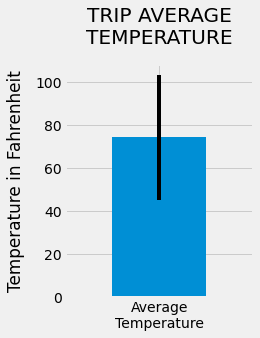

In [85]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(num=None, figsize=(3,4), dpi=None, 
                         facecolor=None, edgecolor=None, frameon=True)

x_axis = 'Average\nTemperature'

y_axis = climate_data[1]

plt.bar(x_axis, y_axis, label='Average temperatures', width=.5, yerr=(climate_data[0]-climate_data[2]))
plt.xlim(-.5, .5)

plt.title("TRIP AVERAGE\nTEMPERATURE", fontsize='x-large',             # Set up title
           loc='center', pad=20)

plt.ylabel("Temperature in Fahrenheit", fontsize='large', labelpad=10)


plt.savefig("output_charts/average_trip_temperature.png", transparent=False)        # Export chart

plt.show()

### Daily Rainfall Average

In [92]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

stmt = session.query(Stations.id, Stations.station, Stations.latitude, Stations.longitude, Stations.elevation, func.sum(Measurements.prcp)).\
    filter(Measurements.station == Stations.station).\
    filter(Measurements.date > '2017-08-01', Measurements.date <= '2017-08-07').\
    group_by(Measurements.station).order_by(func.sum(Measurements.prcp).desc()).statement

rain_per_station = pd.read_sql_query(stmt, session.bind).\
    rename(columns={'id' : 'Station ID', 'station' : 'Station Name', 'latitude' : 'Latitude', 'longitude' : 'Longitude', 'elevation' : 'Elevation', 'sum_1': 'Total Rainfall'})

rain_per_station

,Station ID,Station Name,Latitude,Longitude,Elevation,Total Rainfall
0,9,USC00516128,21.33310,-157.80250,152.4,0.36
1,3,USC00514830,21.52130,-157.83740,7.0,0.10
2,7,USC00519281,21.45167,-157.84889,32.9,0.06
3,1,USC00519397,21.27160,-157.81680,3.0,0.02
4,6,USC00519523,21.33556,-157.71139,19.5,0.00


In [154]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.round(func.avg(Measurement.tobs), 1), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()


In [155]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'


# Use the start and end date to create a range of dates

start_date_dt_object = dt.strptime(start_date, '%Y-%m-%d')
end_date_dt_object = dt.strptime(end_date, '%Y-%m-%d')

date_range = end_date_dt_object - start_date_dt_object


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = [['Date', 'Min Temp', 'Avg Temp', 'Max Temp']]

for i in range(date_range.days+1):
    
    date = (start_date_dt_object + timedelta(days=i)).strftime("%m-%d")
    trip_date = (start_date_dt_object + timedelta(days=i)).strftime("%Y-%m-%d")
    day_set= list(daily_normals(date)[0])
    day_set.insert(0, trip_date)
    normals.append(day_set)

normals
 #(start_date_dt_object + timedelta(days=i).strftime("%Y-%m-%d"), 

[['Date', 'Min Temp', 'Avg Temp', 'Max Temp'],
 ['2017-08-01', 67.0, 75.5, 83.0],
 ['2017-08-02', 68.0, 75.6, 84.0],
 ['2017-08-03', 70.0, 76.6, 85.0],
 ['2017-08-04', 69.0, 76.7, 84.0],
 ['2017-08-05', 69.0, 76.1, 82.0],
 ['2017-08-06', 67.0, 76.3, 83.0],
 ['2017-08-07', 71.0, 77.2, 83.0]]

In [183]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

trip_temp_df=pd.DataFrame(normals[1:], columns=normals[0])

trip_temp_df.set_index('Date', drop=True, inplace=True)
trip_temp_df

,Min Temp,Avg Temp,Max Temp
Date,,,
2017-08-01,67.0,75.5,83.0
2017-08-02,68.0,75.6,84.0
2017-08-03,70.0,76.6,85.0
2017-08-04,69.0,76.7,84.0
2017-08-05,69.0,76.1,82.0
2017-08-06,67.0,76.3,83.0
2017-08-07,71.0,77.2,83.0


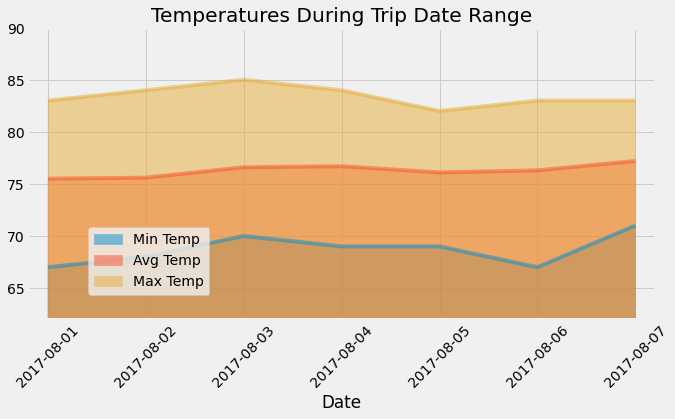

In [202]:
# Plot the daily normals as an area plot with `stacked=False`

#xticks=trip_temp_df['Date'].tolist()
trip_temp_df.plot.area(figsize=(10, 5), 
                       stacked=False, 
                       title='Temperatures During Trip Date Range', 
                       ylim=(min(trip_temp_df['Min Temp'])-5, max(trip_temp_df['Max Temp'])+5), 
                       xlim=(-.2, len(trip_temp_df)-.8), 
                       rot=45, 
                       legend=False
                      )
plt.legend(loc='center right', bbox_to_anchor=(.3, .2))

## Close Session

In [ ]:
# Close Session
session.close()